### Notebook for the testing of `qtr` in the healthy heart reference. 
- **Developed by** Carlos Talavera-López Ph.D
- **Institute of AI for Health - HelmholtzZentrum münchen**
- v210813

The idea is to use `qtr` to evaluate the biological differences between protocols used for the human heart project.  

### Install the latest version of `qtr`

In [1]:
!pip install -e git+https://github.com/theislab/scarches.git@sergey#egg=scarches
!pip install --user scikit-misc

Obtaining scarches from git+https://github.com/theislab/scarches.git@sergey#egg=scarches
  Updating ./src/scarches clone (to revision sergey)
  Running command git fetch -q --tags
  Running command git reset --hard -q 54dc1f1a431c591190853e962012afac17f77dff
  Attempting uninstall: scarches
    Found existing installation: scArches 0.3.5
    Can't uninstall 'scArches'. No files were found to uninstall.
  Running setup.py develop for scarches


In [2]:
pip install --user scikit-misc

### Load required modules 

In [3]:
import torch
import warnings
import numpy as np
import scanpy as sc
import scarches as sca
import matplotlib.pyplot as plt

### Set up working environment

In [4]:
warnings.simplefilter(action = 'ignore')
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 200, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'svg')
torch.set_printoptions(precision = 3, sci_mode = False, edgeitems = 7)

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.7.6
scanpy      1.8.1
sinfo       0.3.4
-----
PIL                         7.1.2
astor                       0.8.1
astunparse                  1.6.3
attr                        21.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.2
cached_property             1.5.2
certifi                     2021.05.30
cffi                        1.14.6
chardet                     3.0.4
cloudpickle                 1.3.0
colorama                    0.4.4
cycler

- Check GPU type assigned by `colab`

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Aug 30 08:59:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Read in single nuclei data from `GDrive`

- Data is anonymised as it only contains raw counts and non-identifiable covariates.  

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Read LV object from the human heart cell atlas. 

- The data was downloaded from the Heart Cell Atlas project [website](https://www.heartcellatlas.org). 
- The left ventricle (LV) data was selected for this analysis to make it more lightweight and focused. 

In [7]:
LV_nuclei = sc.read_h5ad('/content/gdrive/My Drive/data/reference/single_cell/hca_heart_LVnuclei_qtr_7KHVGs_formated.raw.210813.h5ad')
LV_nuclei

AnnData object with n_obs × n_vars = 82806 × 22260
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used', 'Cells_Nuclei', 'combined'
    var: 'gene_ids-Harvard-Nuclei-full', 'feature_types-Harvard-Nuclei-full', 'gene_ids-Sanger-Nuclei-full', 'feature_types-Sanger-Nuclei-full', 'gene_ids-Sanger-Cells-full', 'feature_types-Sanger-Cells-full', 'gene_ids-Sanger-CD45-full', 'feature_types-Sanger-CD45-full', 'n_cells-myeloid', 'n_counts-myeloid', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    layers: 'counts'

### Add module genes

- Here I have selected the C2 modules from the repo, and I have added the C3 Immune-related modules from GSEA. 

In [8]:
path_gmt = '/content/gdrive/My Drive/data/reference/modules/'
#sca.add_annotations(LV_nuclei, 
#                    [path_gmt + 'c2.cp.reactome.v4.0.symbols.gmt', path_gmt + 'c7.all.v7.4.symbols.gmt', path_gmt + 'c3.all.v7.4.symbols.gmt'], 
#                    min_genes = 20, clean = True)
sca.add_annotations(LV_nuclei, 
                    [path_gmt + 'c2.cp.reactome.v4.0.symbols.gmt', path_gmt + 'c3.all.v7.4.symbols.gmt'], 
                    min_genes = 20, clean = True)

LV_nuclei._inplace_subset_var(LV_nuclei.varm['I'].sum(1) > 0)

### Process module genes that match input
- Although the processed data comes with 7K HVGs already labelled in the `adata` object, I selected 2K HVGs to make things faster. 

In [9]:
sc.pp.highly_variable_genes(
    LV_nuclei,
    flavor = "seurat_v3",
    n_top_genes = 5000,
    layer = "counts",
    batch_key = "combined",
    subset = False,
    span = 1
)
LV_nuclei

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 82806 × 17449
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used', 'Cells_Nuclei', 'combined'
    var: 'gene_ids-Harvard-Nuclei-full', 'feature_types-Harvard-Nuclei-full', 'gene_ids-Sanger-Nuclei-full', 'feature_types-Sanger-Nuclei-full', 'gene_ids-Sanger-Cells-full', 'feature_types-Sanger-Cells-full', 'gene_ids-Sanger-CD45-full', 'feature_types-Sanger-CD45-full', 'n_cells-myeloid', 'n_counts-myeloid', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'terms'
    varm: 'I'
    layers: 'counts'

In [10]:
select_terms = LV_nuclei.varm['I'].sum(0) > 20
LV_nuclei.uns['terms'] = np.array(LV_nuclei.uns['terms'])[select_terms].tolist()
LV_nuclei.varm['I'] = LV_nuclei.varm['I'][:, select_terms]
LV_nuclei._inplace_subset_var(LV_nuclei.varm['I'].sum(1) > 0)
LV_nuclei.X-=LV_nuclei.X.mean(0)
LV_nuclei.X = LV_nuclei.layers["counts"].copy()

### Create TRVAE model and train it on reference dataset

In [11]:
intr_cvae = sca.models.TRVAE(
    adata = LV_nuclei,
    condition_key = 'combined',
    hidden_layer_sizes = [1000, 600, 600],
    use_mmd = False,
    recon_loss = 'nb',
    mask = LV_nuclei.varm['I'].T,
    use_decoder_relu = False,
    mmd_instead_kl = False
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 17449 1000 14
	Hidden Layer 1 in/out: 1000 600
	Hidden Layer 2 in/out: 600 600
	Mean/Var Layer in/out: 600 3820
Decoder Architecture:
	Masked linear layer in, out and cond:  3820 17449 14


- Set up training parameters 

In [12]:
ALPHA = 0.7

In [13]:
OMEGA = torch.Tensor(LV_nuclei.varm['I'].sum(0))
OMEGA/=OMEGA.max()
OMEGA*=10

In [14]:
OMEGA = None

In [15]:
LR = 0.0001

In [16]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}

In [17]:
intr_cvae.train(
    n_epochs = 500, 
    alpha_epoch_anneal = 200, 
    alpha = ALPHA, 
    omega = OMEGA,
    alpha_kl = 0.001,
    weight_decay = 0., 
    early_stopping_kwargs = early_stopping_kwargs,
    use_early_stopping = True,
    seed = 1712,
    print_n_deactive = False)

 |█████████-----------| 46.2%  - epoch_loss: 3498.91 - epoch_recon_loss: 3472.62 - epoch_kl_loss: 26285.13 - val_loss: 3597.74 - val_recon_loss: 3581.19 - val_kl_loss: 16550.69
ADJUSTED LR
 |█████████-----------| 47.6%  - epoch_loss: 3484.99 - epoch_recon_loss: 3456.82 - epoch_kl_loss: 28163.93 - val_loss: 3586.80 - val_recon_loss: 3568.89 - val_kl_loss: 17905.67
Stopping early: no improvement of more than 0 nats in 20 epochs
If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.
Saving best state of network...
Best State was in Epoch 216


### Checl terms in results

In [18]:
inactive_idx = ~(intr_cvae.model.decoder.L0.expr_L.weight.data.norm(p = 2, dim = 0) > 0).cpu().numpy()

In [19]:
print('Inactive terms:')
[term for i, term in enumerate(LV_nuclei.uns['terms']) if inactive_idx[i]]

Inactive terms:


['METABOLISM_OF_STEROID_HORMONES',
 'BASIGIN_INTERACTIONS',
 'CHEMOKINE_RECEPTORS_BIND_CHEMO',
 'POST_TRANSLATIONAL_MODIFICATIO',
 'ADP_SIGNALLING_THROUGH_P2RY1',
 'TIGHT_JUNCTION_INTERACTIONS',
 'DOUBLE_STRAND_BREAK_REPAIR',
 'RNA_POL_I_PROMOTER_OPENING',
 'TRAF6_MEDIATED_NFKB_ACTIVATION',
 'TRANSFERRIN_ENDOCYTOSIS_AND_RE',
 'VOLTAGE_GATED_POTASSIUM_CHANNE',
 'CHOLESTEROL_BIOSYNTHESIS',
 'PYRIMIDINE_METABOLISM',
 '5P',
 'TARGET_GENES',
 'TARGET_GENES',
 '01']

### Visualise manifold

In [20]:
LV_nuclei.X = LV_nuclei.X.toarray()

In [21]:
MEAN = True
LV_nuclei.obsm['X_cvae'] = intr_cvae.get_latent(mean = MEAN)[:, ~inactive_idx]

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:03:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:20)


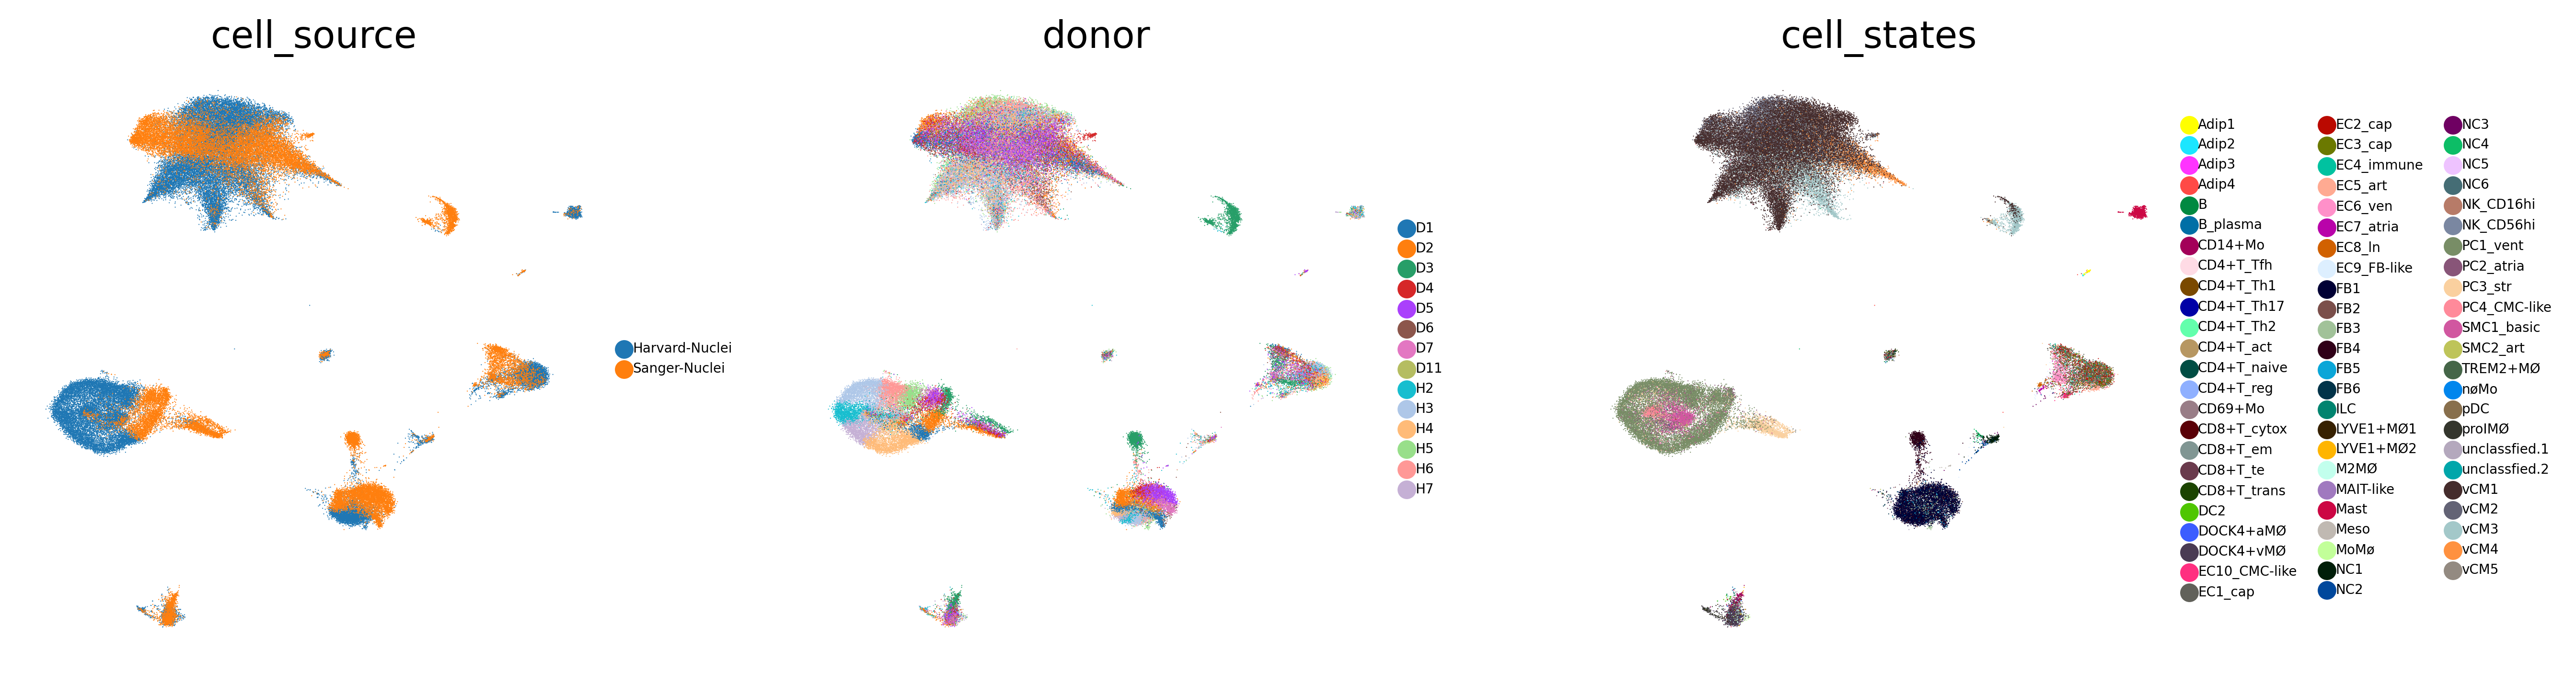

In [22]:
sc.pp.neighbors(LV_nuclei, use_rep = "X_cvae", n_neighbors = 20, metric = 'minkowski')
sc.tl.umap(LV_nuclei, min_dist = 0.3, spread = 2, random_state = 1712)
sc.pl.umap(LV_nuclei, frameon = False, color = ['cell_source', 'donor', 'cell_states'], size = 0.6, legend_fontsize = 5)

### Read in cells data

In [23]:
LV_cells = sc.read_h5ad('/content/gdrive/My Drive/data/reference/single_cell/hca_heart_LVcells_qtr_7KHVGs_formated.raw.210813.h5ad')[:, LV_nuclei.var_names].copy()
LV_cells

AnnData object with n_obs × n_vars = 16681 × 17449
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used', 'Cells_Nuclei', 'combined'
    var: 'gene_ids-Harvard-Nuclei-full', 'feature_types-Harvard-Nuclei-full', 'gene_ids-Sanger-Nuclei-full', 'feature_types-Sanger-Nuclei-full', 'gene_ids-Sanger-Cells-full', 'feature_types-Sanger-Cells-full', 'gene_ids-Sanger-CD45-full', 'feature_types-Sanger-CD45-full', 'n_cells-myeloid', 'n_counts-myeloid', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    layers: 'counts'

### Format cells for analysis 

### Train on cells

In [24]:
q_intr_cvae = sca.models.TRVAE.load_query_data(LV_cells, intr_cvae)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 17449 1000 23
	Hidden Layer 1 in/out: 1000 600
	Hidden Layer 2 in/out: 600 600
	Mean/Var Layer in/out: 600 3820
Decoder Architecture:
	Masked linear layer in, out and cond:  3820 17449 23


In [25]:
LV_cells.X = LV_cells.X.toarray()

In [26]:
q_intr_cvae.train(n_epochs = 500, alpha_epoch_anneal = 200, weight_decay = 0., alpha_kl = 0.001, seed = 1786)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |███-----------------| 15.2%  - epoch_loss: 4077.76 - epoch_recon_loss: 4066.45 - epoch_kl_loss: 30175.44 - val_loss: 3971.79 - val_recon_loss: 3960.60 - val_kl_loss: 29824.52
ADJUSTED LR
 |███-----------------| 17.4%  - epoch_loss: 4056.63 - epoch_recon_loss: 4043.67 - epoch_kl_loss: 30142.13 - val_loss: 4034.70 - val_recon_loss: 4021.93 - val_kl_loss: 29696.47
ADJUSTED LR
 |███-----------------| 19.4%  - epoch_loss: 4037.14 - epoch_recon_loss: 4022.68 - epoch_kl_loss: 30128.90 - val_loss: 4049.45 - val_recon_loss: 4035.19 - val_kl_loss: 29717.14
ADJUSTED LR
 |████----------------| 20.8%  - epoch_loss: 4069.16 - epoch_recon_loss: 4053.66 - epoch_kl_loss: 30079.47 - val_loss: 4103.98 - val_recon_loss: 4088.65 - val_kl_loss: 29764.13
ADJUSTED LR
 |████----------------| 22.0%  - epoch_loss: 4078.99 - epoch_recon_loss: 4062.58 - epoch_kl_loss: 30114.10 - val_loss: 4000.91 - val_recon_loss: 3984.70 - val_kl_loss: 29745.27
Stopping early: no improvement of more than 0 nats in 20 epochs
If 

### Visualise joint manifold

In [27]:
LV_cells.obsm['X_cvae'] = q_intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:21)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:24)


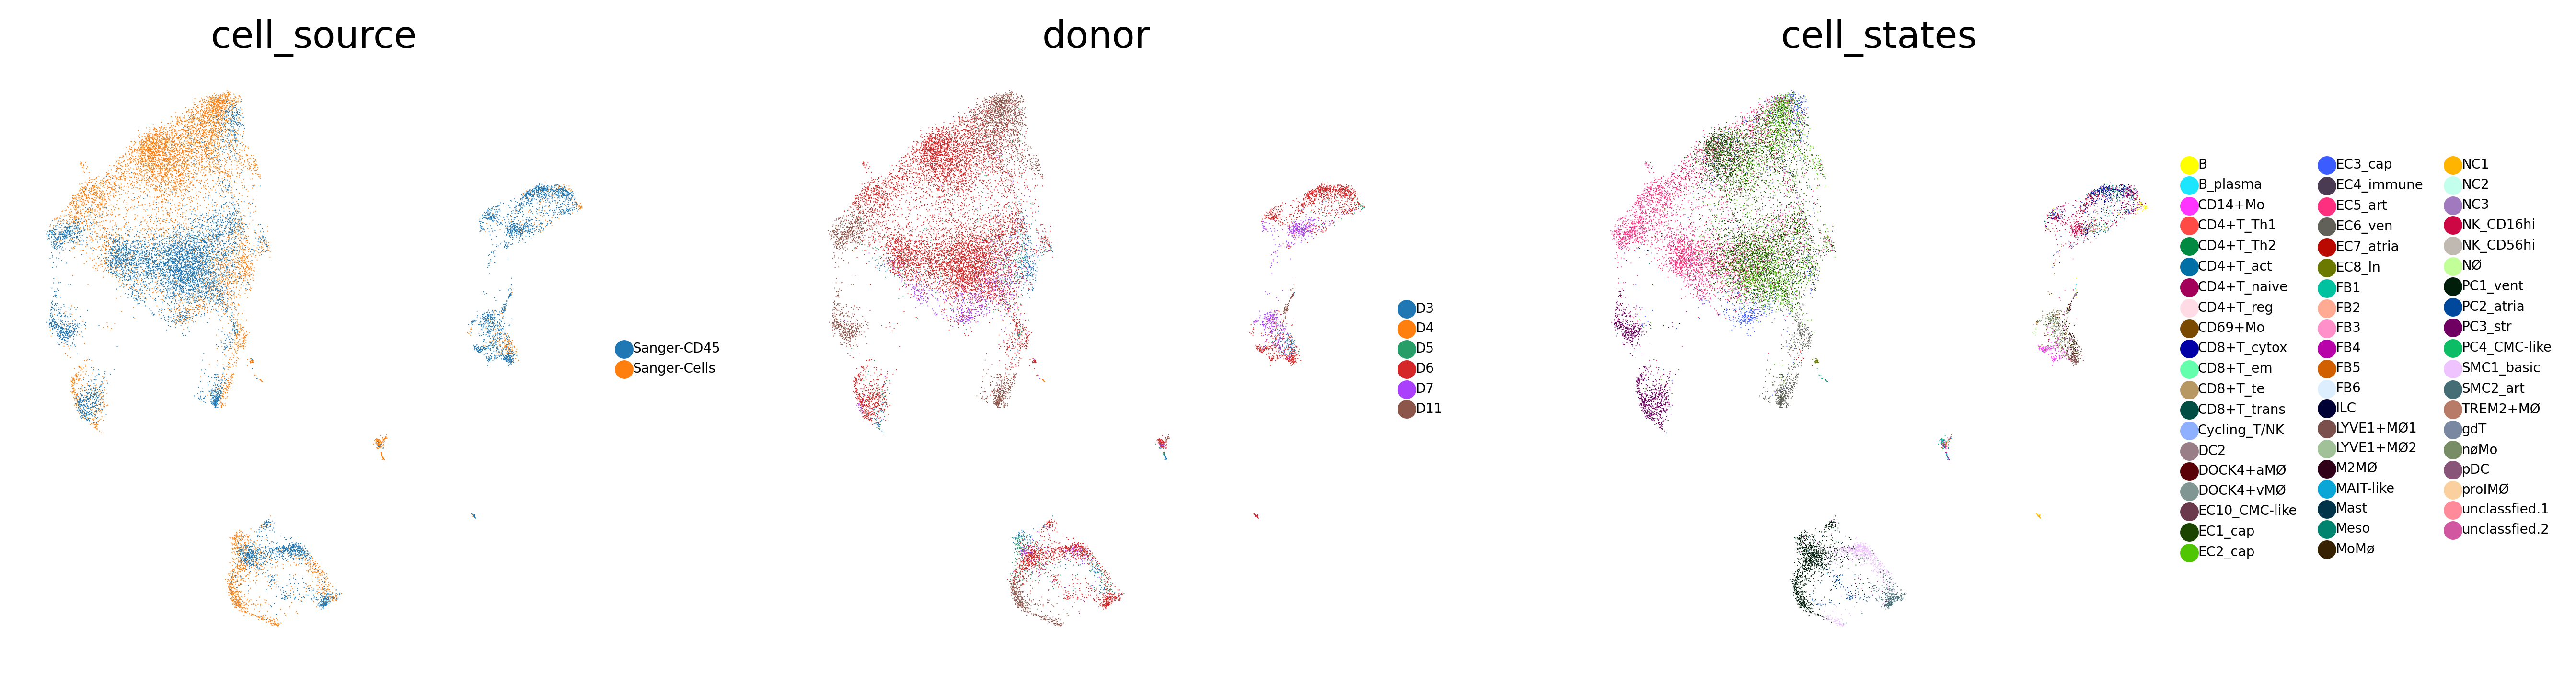

In [28]:
sc.pp.neighbors(LV_cells, use_rep = "X_cvae", n_neighbors = 20, metric = 'minkowski')
sc.tl.umap(LV_cells, min_dist = 0.3, spread = 2, random_state = 1712)
sc.pl.umap(LV_cells, frameon = False, color = ['cell_source', 'donor', 'cell_states'], size = 0.6, legend_fontsize = 5)

### Subset terms of interest

In [29]:
terms = LV_nuclei.uns['terms']
terms

['TRANSLATION',
 'RNA_POL_III_TRANSCRIPTION_INIT',
 'PYRUVATE_METABOLISM_AND_CITRIC',
 'PTM_GAMMA_CARBOXYLATION_HYPUSI',
 'APOPTOTIC_CLEAVAGE_OF_CELLULAR',
 'FORMATION_OF_THE_TERNARY_COMPL',
 'ACTIVATION_OF_THE_PRE_REPLICAT',
 'BILE_ACID_AND_BILE_SALT_METABO',
 'SIGNALING_BY_RHO_GTPASES',
 'SIGNALING_BY_WNT',
 'METABOLISM_OF_NON_CODING_RNA',
 'METABOLISM_OF_STEROID_HORMONES',
 'SIGNALLING_BY_NGF',
 'SIGNALING_BY_SCF_KIT',
 'DEVELOPMENTAL_BIOLOGY',
 'CROSS_PRESENTATION_OF_SOLUBLE_',
 'DAG_AND_IP3_SIGNALING',
 'TCA_CYCLE_AND_RESPIRATORY_ELEC',
 'BMAL1_CLOCK_NPAS2_ACTIVATES_CI',
 'ANTIGEN_PROCESSING_CROSS_PRESE',
 'TRIF_MEDIATED_TLR3_SIGNALING',
 'CELL_CELL_COMMUNICATION',
 'ER_PHAGOSOME_PATHWAY',
 'MEIOSIS',
 'NEGATIVE_REGULATION_OF_FGFR_SI',
 'G0_AND_EARLY_G1',
 'MEMBRANE_TRAFFICKING',
 'IMMUNOREGULATORY_INTERACTIONS_',
 'METABOLISM_OF_VITAMINS_AND_COF',
 'TRANS_GOLGI_NETWORK_VESICLE_BU',
 'CELL_CYCLE',
 'SIGNALING_BY_ERBB4',
 'ORC1_REMOVAL_FROM_CHROMATIN',
 'O_LINKED_GLYCOSYLATION_OF_M

In [30]:
idx = [terms.index(term) for term in ['CYTOKINE_SIGNALING_IN_IMMUNE_S', 'INNATE_IMMUNE_SYSTEM', 'SIGNALING_BY_NOTCH']]
latents = q_intr_cvae.get_latent(mean=MEAN)[:, idx]

- Explore terms in cell data

In [31]:
LV_cells.obs['CYTOKINE_SIGNALING_IN_IMMUNE_S'] = latents[:, 0]
LV_cells.obs['INNATE_IMMUNE_SYSTEM'] = latents[:, 1]
LV_cells.obs['SIGNALING_BY_NOTCH'] = latents[:, 2]

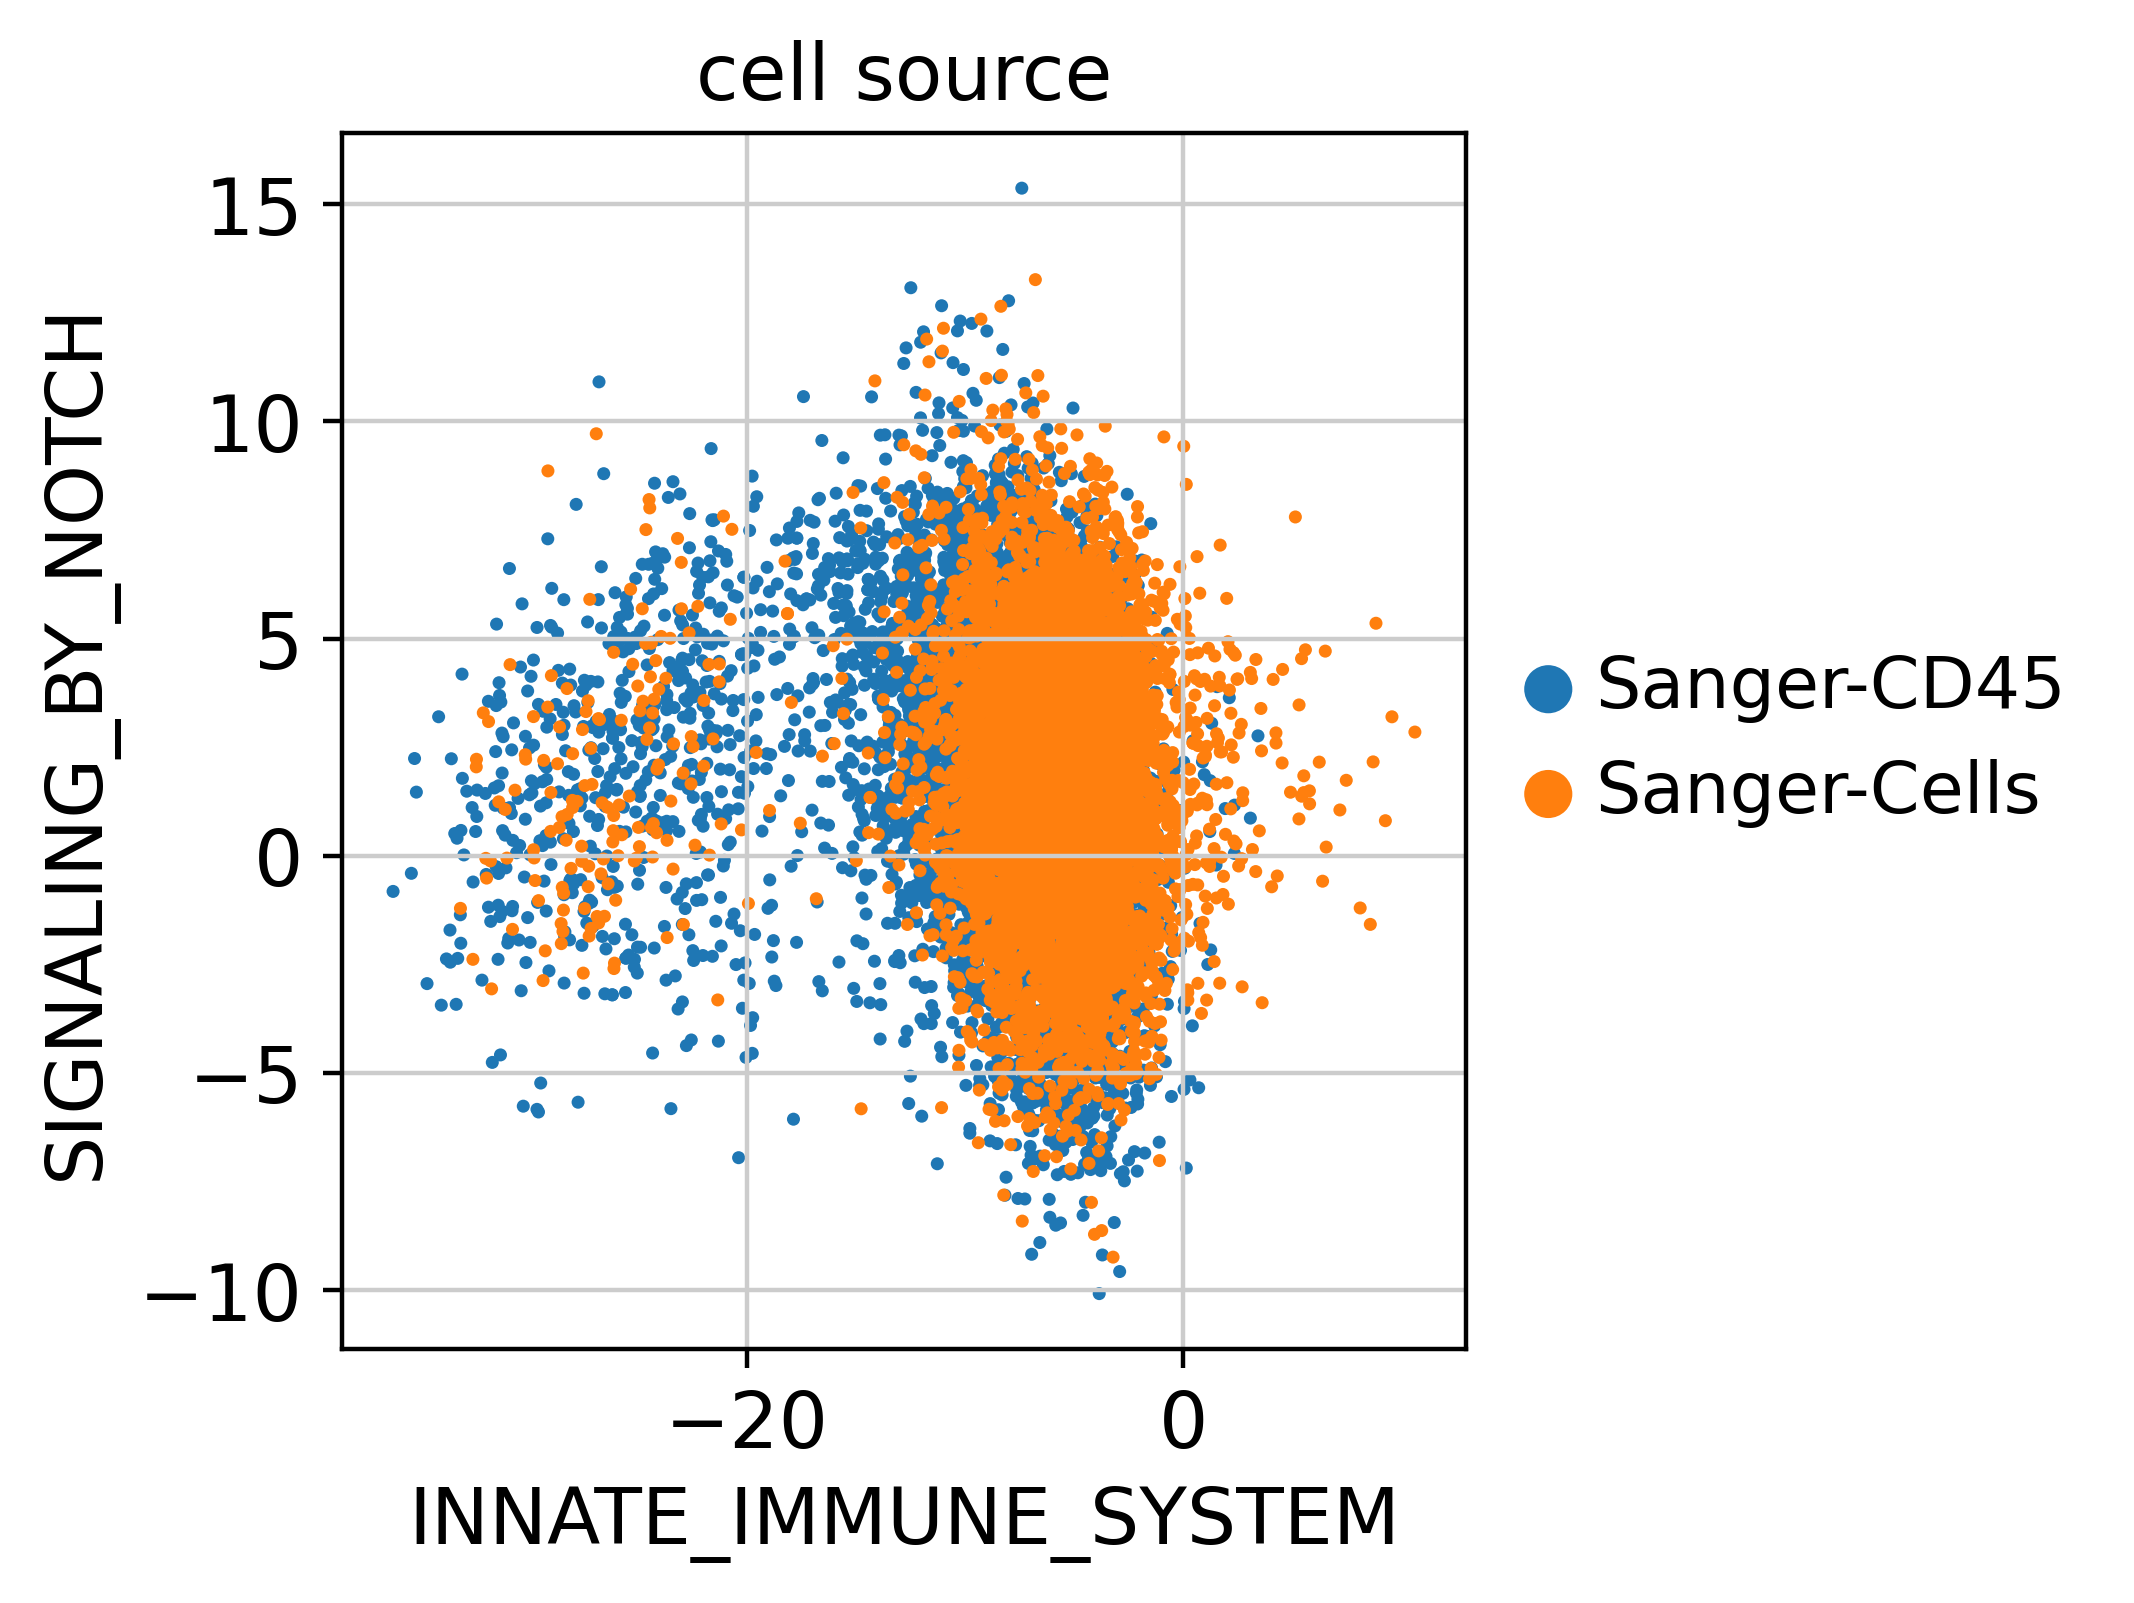

In [32]:
sc.pl.scatter(LV_cells, x = 'INNATE_IMMUNE_SYSTEM', y = 'SIGNALING_BY_NOTCH', color = 'cell_source', size = 22)

In [ ]:
latents = intr_cvae.get_latent(mean=MEAN)[:, idx]

In [ ]:
LV_nuclei.obs['INNATE_IMMUNE_SYSTEM'] = latents[:, 0]
LV_nuclei.obs['SIGNALING_BY_NOTCH'] = latents[:, 1]

In [ ]:
sc.pl.scatter(LV_nuclei, x = 'INNATE_IMMUNE_SYSTEM', y = 'SIGNALING_BY_NOTCH', color='cell_source', size = 22)

### Get joint representation

In [ ]:
heart_LV = sc.AnnData.concatenate(LV_nuclei, LV_cells, batch_key = 'batch_join')
heart_LV

In [ ]:
heart_LV.obsm['X_cvae'] = q_intr_cvae.get_latent(heart_LV.X, heart_LV.obs['combined'].tolist(), mean = MEAN)[:, ~inactive_idx]

In [ ]:
sc.pp.neighbors(heart_LV, use_rep = "X_cvae", n_neighbors = 20, metric = 'minkowski')
sc.tl.umap(heart_LV, min_dist = 0.3, spread = 2, random_state = 1712)
sc.pl.umap(heart_LV, frameon = False, color = ['cell_source', 'donor', 'cell_states'], size = 0.6, legend_fontsize = 5)